Bonjour à vous, voici ma petite étude sur le sujet donner pour Tictactrip : 

In [203]:
import scipy.io
import numpy as np
import scipy
from numpy import linalg as LA
from scipy.spatial import procrustes
import matplotlib.pyplot as plt
from scipy.spatial import procrustes
from math import atan
import math
from scipy.linalg import norm
from scipy.io import loadmat
import pandas as pd
from sklearn.neighbors import DistanceMetric

Objectif :
   - extraire des infos intéressantes type prix min, moyen et max, durée min/max/moyenne par trajet
   - différence de prix moyen et durée selon le train, le bus et le covoit selon la distance du trajet (0-200km, 201-800km, 800-2000km, 2000+km) 



### Démarche 
J'ai décider de diviser mon étude en 2 gros points, l'étude feature par feature (1D) et une autre partie en croisant les feature entres elles (je ne vais que jusqu'en 2D)

### Stats 1D sur la table ticket_data

In [204]:
# chargement des datasets 
cities = pd.read_csv("data/cities.csv")
stations = pd.read_csv("data/stations.csv")
providers = pd.read_csv("data/providers.csv")
ticket_data = pd.read_csv("data/ticket_data.csv")

#### Stats sur le prix 

Text(0.5, 0.98, 'Boxplot des prix en centimes')

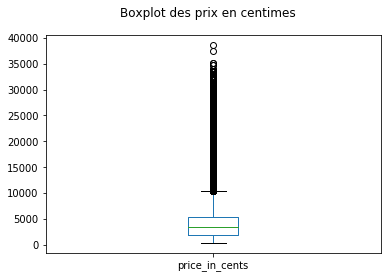

In [205]:
#idée : pour représenté le min max et moyenne, faire des boîtes à moustache
#Faire pour le prix
ticket_data.price_in_cents.plot.box()
plt.suptitle("Boxplot des prix en centimes")

On remarque que les outliers sont nombreux et ont une réelle influence sur le prix:   

In [206]:
print("avec outliers")
print("prix min(euros)",ticket_data.price_in_cents.min()/100)
print("prix max (euros)",ticket_data.price_in_cents.max()/100)
print("prix moyen (euros)",ticket_data.price_in_cents.mean()/100)

avec outliers
prix min(euros) 3.0
prix max (euros) 385.5
prix moyen (euros) 43.82711061374178


In [207]:
print("sans outliers")
ticket_data_no_outliers = ticket_data[ticket_data.price_in_cents<=10000]
print("prix min(euros)",test.price_in_cents.min()/100)
print("prix max (euros)",test.price_in_cents.max()/100)
print("prix moyen (euros)",test.price_in_cents.mean()/100)

sans outliers
prix min(euros) 3.0
prix max (euros) 100.0
prix moyen (euros) 33.15288512043317


In [208]:
ticket_data_avec_outliers = ticket_data[ticket_data.price_in_cents>10000]

Pour le moment on va donc enlever les outliers de notre dataset. 

#### Stats sur la durée  

In [209]:
# create new column : temps_trajet_in_minute
ticket_data_no_outliers.departure_ts = pd.to_datetime(ticket_data_no_outliers.departure_ts,
                                          format='%Y-%m-%d %H:%M:%S',
                                          errors='ignore')
ticket_data_no_outliers.arrival_ts = pd.to_datetime(ticket_data_no_outliers.arrival_ts,
                                          format='%Y-%m-%d %H:%M:%S',
                                          errors='ignore')
ticket_data_no_outliers["temps_trajet_in_minute"] = (ticket_data_no_outliers.arrival_ts - ticket_data_no_outliers.departure_ts).astype('timedelta64[m]')

C:\Users\theo\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\theo\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [210]:
ticket_data_no_outliers["temps_trajet_in_minute"].describe()

count    67863.000000
mean       414.295581
std        585.805607
min         20.000000
25%        170.000000
50%        290.000000
75%        475.000000
max      29571.000000
Name: temps_trajet_in_minute, dtype: float64

#### Stats 1D sur les ompagnies

Text(0.5, 0.98, 'Répartition des compagnies')

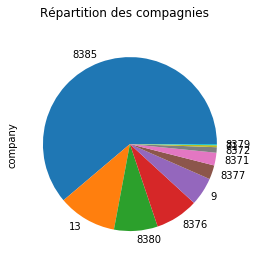

In [211]:
ticket_data_no_outliers.company.value_counts().head(n=10).plot.pie()
plt.suptitle("Répartition des compagnies")

On remarque que plus 3/4 des voyages ont été commandés par les entreprises n°8385, n°8376 , n°13 et n°8380, 
dont la moitié par n°8385.    
PS :Le fait de joindre les le dataset providers et tickets ne permet pas d'avoir toutes les informations(il manque des numéros de compagnie).

#### Stats 1D sur les dstances 

Dans cette partie, Je vais calculer la distance entre la ville de départ et la ville d'arrivée.
Il y a cependant des points à améliorer : 
- je ne prends pas en compte le champ "middle_stations"
- je ne prends pas en compte le champ "o_station" & "d_station" 

In [212]:
# voici la manière dont je me suis prit pour calculer la distance. 
def get_distance(lat1,lat2,lon1,lon2):
    difflon = lon2 - lon1
    difflat = lat2 - lat1

    haversin_formule = np.cos(lat1) * np.cos(lat2) * np.sin(difflon/2.0)**2 + np.sin(difflat/2.0)**2 

    dist = 2 * np.arcsin(np.sqrt(haversin_formule ))
    km = 6367 * dist  
    return km

In [213]:
# merge bien le dataset ticket_data et cities pour faire le calcul de distances
#1) merge pour le ville de départ
data_distance = ticket_data_no_outliers.merge(cities[['id',"latitude","longitude","unique_name"]]
                                  ,left_on ='o_city' ,right_on = 'id',how="left")
data_distance = data_distance.rename(columns={'latitude': 'o_latitude', 'longitude': 'o_longitude',
                                             "unique_name":"o_city_name"})
#2) merge pour le ville de fin
data_distance = data_distance.merge(cities[['id',"latitude","longitude","unique_name"]]
                                  ,left_on ='d_city' ,right_on = 'id',how="left")

data_distance = data_distance.rename(columns={'latitude': 'd_latitude', 'longitude': 'd_longitude',
                                             "unique_name":"d_city_name"})

In [214]:
#3) on convertis les longitude et latitude en radians
data_distance['o_latitude'] = np.radians(data_distance['o_latitude'])
data_distance['o_longitude'] = np.radians(data_distance['o_longitude'])
data_distance['d_latitude'] = np.radians(data_distance['d_latitude'])
data_distance['d_longitude'] = np.radians(data_distance['d_longitude'])

In [215]:
data_distance["distance"] = get_distance(data_distance['o_latitude'],
                                     data_distance['d_latitude'] ,
                                    data_distance['o_longitude'],
                                    data_distance['d_longitude'])

Text(0.5, 0.98, 'Répartition des distances des trajets')

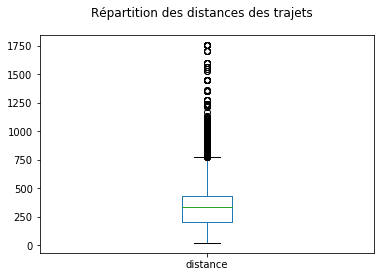

In [216]:
data_distance.distance.plot.box()
plt.suptitle("Répartition des distances des trajets")

In [217]:
print("distance min(km)",data_distance.distance.min())
print("distance max (km)",data_distance.distance.max())
print("distance moyen (km)",data_distance.distance.mean())

distance min(km) 18.901366958390767
distance max (km) 1754.9543216930806
distance moyen (km) 345.4008271197539


#### Stat 1D moyen de transport

In [218]:
#join des datasets
providers = providers.rename(columns={'company_id' :'company'})
distance_company = data_distance.merge(providers,on = 'company',how="left")

In [219]:
distance_company.transport_type.value_counts(normalize =True)

bus           0.999867
train         0.000126
carpooling    0.000007
Name: transport_type, dtype: float64

Remarque : plus de 99,98 % des voyage se font en bus.

### Stats 2D  

#### durée min/max/moyenne par trajet  

Dans cette partie, par soucis de clarté je choisis de ne faire mes calculs que sur les 10 trajets les plus "fréquentés". 

In [220]:
# On va prendre les 10 distances des trajets les plus fréquenté.
distances_trajets_freq = data_distance.distance.value_counts().head(n= 10)

In [221]:
# je filtre
trajets_top_10 = data_distance[data_distance.distance.isin(list_distances_trajets_freq)]

In [228]:
# je groupby par  ville de départ et ville d'arrivée
groupby = trajets_top_10[["d_city_name","o_city_name","temps_trajet_in_minute"]].groupby(['o_city_name',"d_city_name"])

In [229]:
# je construis mon dataframe de résultat 
resultat = groupby.max().rename(columns={'temps_trajet_in_minute' :'Max_minute'})
resultat["Min_minute"] = groupby.min()
resultat["Moyenne_minute"] = groupby.mean()     
resultat["count"] = groupby.count()  

In [231]:
# je tris par nombre pour éviter de prendre les doublons : 
# ex : Paris->Lille ET Lille -> Paris 
resultat.sort_values(by='count' , ascending=False).head(n=10)

Max_minute  Min_minute  Moyenne_minute  count
o_city_name d_city_name                                               
paris       lille            2240.0        68.0      218.384877   6176
            lyon             1711.0       180.0      340.757369   4105
lyon        paris            2493.0       129.0      367.060134   3276
paris       nantes           2424.0       136.0      299.460408   2450
            orleans          1720.0        20.0      108.039370   1270
            bordeaux         2420.0       152.0      419.518236   1179
nantes      paris            2406.0       164.0      344.743952    992
dijon       lyon             1560.0       100.0      177.734841    973
paris       amsterdam        2200.0       236.0      549.234323    909
            rennes           1880.0       123.0      271.097222    864

Remarque : Voici le temps max, le temps min et le temps moyen de trajet selon la ville de départ et la destination.

#### Prix moyen et durée selon le train, le bus et le covoit 

In [234]:
#join des datasets
providers = providers.rename(columns={'company_id' :'company'})
distance_provider = data_distance.merge(providers,on = 'company',how="left")

In [235]:
price_in_cents_par_transport_type = distance_provider.groupby(["transport_type"]).price_in_cents

In [237]:
resultat = pd.DataFrame({
   'Max_prix': price_in_cents_par_transport_type.max(),
    'Min_prix':price_in_cents_par_transport_type.min(),
    "mean_prix":price_in_cents_par_transport_type.mean(),
    "nombre d'échantillons":price_in_cents_par_transport_type.count()
    
    })

In [238]:
resultat
# REMARQUE : on ne peut pas en déduire qqchose car l'échantillon est trop petit pour le carpooling
# et le train

,Max_prix,Min_prix,mean_prix,nombre d'échantillons
transport_type,,,,
bus,9700,850,3299.086153,712755
carpooling,4777,1990,3868.800000,5
train,5200,2400,3265.555556,90


#### Prix moyen & durée moyen en fonction de la distance

In [241]:
#changement de la feature distance (float) en  categorical [(0, 200), (201, 400), (401, 800),(801,2000)]
bins = pd.IntervalIndex.from_tuples([(0, 200), (201, 400), (401, 800),(801,2000)])
distance_provider.distance = pd.cut(distance_provider.distance, bins)

#####  Prix moyen en fonciton de la distance

In [242]:
distance_provider.groupby(["distance"]).price_in_cents.mean()

distance
(0, 200]       2014.993381
(201, 400]     2662.603747
(401, 800]     3826.171945
(801, 2000]    5850.098319
Name: price_in_cents, dtype: float64

In [248]:
#Nombre d'échantillon par catégorie
print("Nombre des échantillons par catégorie")
distance_provider.groupby(["distance"]).price_in_cents.count()

Nombre des échantillons par catégorie


distance
(0, 200]        80678
(201, 400]     278908
(401, 800]     371015
(801, 2000]     41772
Name: price_in_cents, dtype: int64

Après avoir fait des intervalles de confiance, on se rends compte que les différences de prix sont bien significatives à 95% pour chaque catégorie.

Text(0.5, 0.98, 'barplot des prix (centimes) par distance')

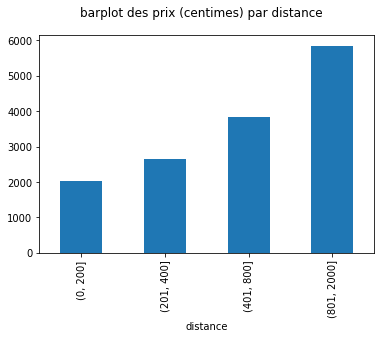

In [250]:
distance_provider.groupby(["distance"]).price_in_cents.mean().plot.bar()
plt.suptitle("barplot des prix moyens(centimes) par distance")

#####  Temps moyen en fonciton de la distance

Text(0.5, 0.98, 'barplot du temps moyens(minutes) par distance')

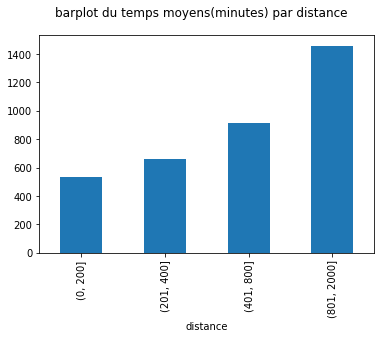

In [251]:
test.groupby(["distance"]).temps_trajet_in_minute.mean().plot.bar()
plt.suptitle("barplot du temps moyen(minutes) par distance")